
### This script runs hyperparam selection for one-hop traversal on graph using natural language. Before running this notebook, make sure to run: codes/py_scripts/rag_based_text_generation/GPT/drug_repurposing_hyperparameter_tuning.py 
### This will save the csv files that are used in this notebook


In [40]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem


In [41]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection    
    if union == 0:
        return 0.0
    else:
        jaccard_similarity = intersection / union
        return jaccard_similarity
    
def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    
def extract_by_splitting(text):
    compound_list = text.split(':')[1].split("Diseases")[0].split("], ")[0]+"]"
    disease_list = text.split(':')[-1].split("}")[0]
    resp = {}
    resp["Compounds"] = ast.literal_eval(compound_list)
    resp["Diseases"] = ast.literal_eval(disease_list)
    return resp
    

In [42]:
PARENT_PATH = "../../../data/analysis_results/"

QUESTION_PATH = os.path.join(PARENT_PATH, "drug_reporposing_questions.csv")

FILES = [
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_1.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_2.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_3.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_4.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_5.csv"
]


In [43]:
llm_performance_list = []
for file in tqdm(FILES):
    df = pd.read_csv(os.path.join(PARENT_PATH, file))
    df.dropna(subset=["llm_answer"], inplace=True)
    llm_performance_list_across_questions = []
    for index, row in df.iterrows():
        cmp_gt = ast.literal_eval(row["compound_groundTruth"])
        disease_gt = ast.literal_eval(row["disease_groundTruth"])
        try:
            llm_answer = json.loads(extract_answer(row["llm_answer"]))
        except:
            llm_answer = extract_by_splitting(row["llm_answer"])
        cmp_llm = llm_answer["Compounds"]
        disease_llm = llm_answer["Diseases"]
        cmp_similarity = jaccard_similarity(cmp_gt, cmp_llm)
        disease_similarity = jaccard_similarity(disease_gt, disease_llm)
        llm_performance = np.mean([cmp_similarity, disease_similarity])
        llm_performance_list_across_questions.append(llm_performance)
    llm_performance_list.append((np.mean(llm_performance_list_across_questions), np.std(llm_performance_list_across_questions), sem(llm_performance_list_across_questions), row["context_volume"]))
        


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 59.09it/s]


In [44]:
llm_performance_list

[(0.4197612881775139, 0.21749284083141995, 0.02528302919033789, 10),
 (0.6229523641951725, 0.1900950186377321, 0.02209809705359867, 50),
 (0.6614604806949865, 0.1779324590711616, 0.020684228222903802, 100),
 (0.6670208068454874, 0.1791102191529415, 0.020821140051417445, 150),
 (0.6686741581867187, 0.17693461668731914, 0.02056823140194361, 200)]

In [45]:
hyperparam_perf = pd.DataFrame(llm_performance_list, columns=["performance_mean", "performance_std", "performance_sem", "context_volume"])
hyperparam_perf


,performance_mean,performance_std,performance_sem,context_volume
0,0.419761,0.217493,0.025283,10
1,0.622952,0.190095,0.022098,50
2,0.661460,0.177932,0.020684,100
3,0.667021,0.179110,0.020821,150
4,0.668674,0.176935,0.020568,200


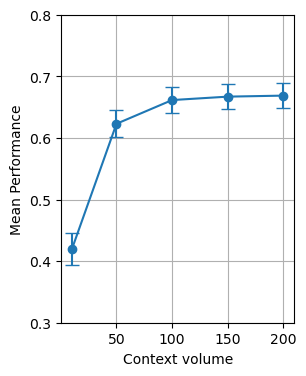

In [48]:


params = hyperparam_perf.context_volume.values
mean_performance = hyperparam_perf.performance_mean.values
std_deviation = hyperparam_perf.performance_std.values
sem_value = hyperparam_perf.performance_sem.values

fig = plt.figure(figsize=(3, 4))
plt.errorbar(params, mean_performance, yerr=sem_value, fmt='o-', capsize=5, label='Performance')
plt.xlabel('Context volume')
plt.ylabel('Mean Performance')
plt.grid(True)
plt.ylim(0.3,0.8)
plt.show()

figure_folder_name = "hyperparam_tuning"
fig_filename = "../../../data/analysis_results/figures/{}/context_volume_one_hop.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')

